In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

!pip install imbalanced-learn   

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBRegressor

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

Problem Statement 

Assuming you’re the data scientist working in the office of alumni of a university. Every year, the university receives donations from a set of people, who might be staff, alumni, external organization, someone not directly related, … To help with the fund-raising, the university decides to reach out to individuals by sending greetings privately and other actions. 

The following hypothetical dataset simulates the demographics information from two population, folks who had donated money to the university in the past and folks who never.

The problem statement is as follows – among those who do not have donation histories, who may be the potential donors and be converted to become the next donors once got in touch?

Instead of prescribing a strict approach we would leave it up to you to decide what kind of machine learning approach you would want to take. 

At the core of it, this is a predictive modelling challenge. Although, you may decide if you want to treat it as a classification/regression problem.

Data

Per mentioned above, there are two population provided, which can be distinguished by the column donor_or_not. Please make necessary assumptions and call them out in your code/submission.

NOTE: The data is masked to avoid any potential confusion with actual transactions. As such you will not be able to join any other relevant information you might find in the open-source domain. We request you to confine your analysis to the data provided.



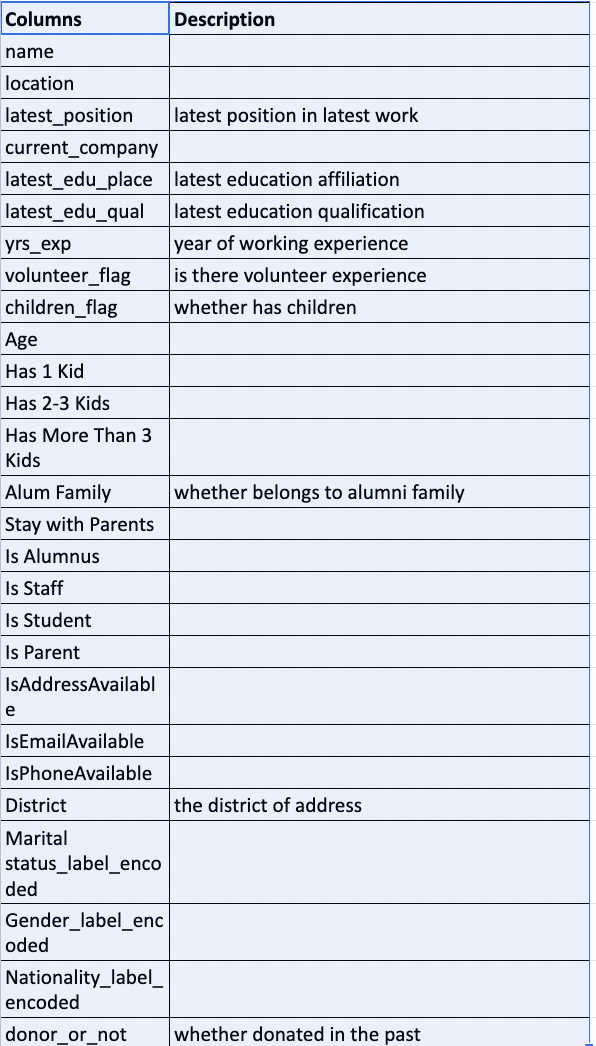

In [4]:
df_real=pd.read_excel("University_donations.xlsx")

In [5]:
df_real.children_flag.value_counts()

8ce86a6ae65d3692e7305e2c58ac62eebd97d3d943e093f577da25c36988246b    1102
18f5384d58bcb1bba0bcd9e6a6781d1a6ac2cc280c330ecbab6cb7931b721552      56
Name: children_flag, dtype: int64

In [6]:
df_real['Has 1 Kid'].value_counts()

8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e7b6f554b06f75550d7    1145
d0ff5974b6aa52cf562bea5921840c032a860a91a3512f7fe8f768f6bbe005f6      11
9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0       2
Name: Has 1 Kid, dtype: int64

In [7]:
df_real['Has 2-3 Kids'].value_counts()

8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e7b6f554b06f75550d7    1154
d0ff5974b6aa52cf562bea5921840c032a860a91a3512f7fe8f768f6bbe005f6       2
9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0       2
Name: Has 2-3 Kids, dtype: int64

In [8]:
df_real['Has More Than 3 Kids'].value_counts()

8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e7b6f554b06f75550d7    1156
9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0       2
Name: Has More Than 3 Kids, dtype: int64

Tried to get a relevance for the encoded values. 

In [9]:
df_real.columns

Index(['name', 'location', 'latest_position', 'current_company', 'latest_edu_place', 'latest_edu_qual', 'yrs_exp', 'volunteer_flag', 'children_flag', 'Age', 'Has 1 Kid', 'Has 2-3 Kids', 'Has More Than 3 Kids', 'Alum Family', 'Stay with Parents', 'Is Alumnus', 'Is Staff', 'Is Student', 'Is Parent', 'IsAddressAvailable', 'IsEmailAvailable', 'IsPhoneAvailable', 'District', 'Marital status_label_encoded', 'Gender_label_encoded', 'Nationality_label_encoded', 'donor_or_not'], dtype='object')

In [10]:
df_real.shape

(1158, 27)

In [11]:
df_real.donor_or_not.value_counts(dropna=False)

1.0    1141
0.0      15
NaN       2
Name: donor_or_not, dtype: int64

Class Imbalanced data set

In [12]:
df = df_real.loc[df_real.donor_or_not.notnull(),:]

In [13]:
def null_val_check(df):
  for cols in df.columns:
    if df[cols].isnull().sum() > 0:
      print(cols,df[cols].isnull().sum())
    elif (df.loc[df[cols].astype(str).str.len() == 0,:].shape[0]>0):
      print(cols,df.loc[df[cols].astype(str).str.len() == 0,:].shape[0])
null_val_check(df)

There are two null values in donor_or_not for which don't have any history. we need to find for these rows

In [14]:
print("""getting the null value rows""")
df_real.loc[df_real.donor_or_not.isnull(),:]

getting the null value rows


,name,location,latest_position,current_company,latest_edu_place,latest_edu_qual,yrs_exp,volunteer_flag,children_flag,Age,Has 1 Kid,Has 2-3 Kids,Has More Than 3 Kids,Alum Family,Stay with Parents,Is Alumnus,Is Staff,Is Student,Is Parent,IsAddressAvailable,IsEmailAvailable,IsPhoneAvailable,District,Marital status_label_encoded,Gender_label_encoded,Nationality_label_encoded,donor_or_not
829,7ff3aca787e6b5cf4dc03951b7521ab39e349fd62a67ef...,6f8baeb8c2912288741d8217e2c720b4af541e825ba7ed...,ce8b7dc6dc1fea1ccdd79a01850069caa9895340e329d3...,4e1524d400c5b476ea0a8c9e36a8e1c35305c647c7dd41...,dc937b59892604f5a86ac96936cd7ff09e25f18ae6b758...,dc937b59892604f5a86ac96936cd7ff09e25f18ae6b758...,dc937b59892604f5a86ac96936cd7ff09e25f18ae6b758...,8ce86a6ae65d3692e7305e2c58ac62eebd97d3d943e093...,8ce86a6ae65d3692e7305e2c58ac62eebd97d3d943e093...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,NaN
1144,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,ca9f6563c7614c5ef5f033c9aaa1aa21611412da771a91...,40a2ed2249c515fbd7c217c581607f90272f4dc1576ca0...,e821245e5cf2de38296c2848ae2438b8d12ded1b831c83...,d81ffc4257cf3d17ac099f56a8fee8604a76b53c8aaa76...,0c2db2d9c9905217d2d9477c490d5d48ffcc08de4f5c9a...,2c624232cdd221771294dfbb310aca000a0df6ac8b66b6...,8ce86a6ae65d3692e7305e2c58ac62eebd97d3d943e093...,8ce86a6ae65d3692e7305e2c58ac62eebd97d3d943e093...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,NaN


In [15]:
df.shape

(1156, 27)

In [16]:
def unique_val_check(df):
  return df.nunique(dropna=False) 

In [17]:
unique_val_check(df)

name                            1145
location                          48
latest_position                  822
current_company                  900
latest_edu_place                 140
latest_edu_qual                    5
yrs_exp                           46
volunteer_flag                     2
children_flag                      2
Age                               51
Has 1 Kid                          2
Has 2-3 Kids                       2
Has More Than 3 Kids               1
Alum Family                        2
Stay with Parents                  2
Is Alumnus                         2
Is Staff                           2
Is Student                         2
Is Parent                          1
IsAddressAvailable                 2
IsEmailAvailable                   2
IsPhoneAvailable                   2
District                          28
Marital status_label_encoded       4
Gender_label_encoded               3
Nationality_label_encoded         22
donor_or_not                       2
d

Rows of Df is 1156, where as there are 1145 names. Need to check the names that are repeating 

In [18]:
duplicate_names=list(df.loc[df.duplicated('name'),'name'])

In [19]:
df.loc[df.name.isin(duplicate_names),:].sort_values(by='name')

,name,location,latest_position,current_company,latest_edu_place,latest_edu_qual,yrs_exp,volunteer_flag,children_flag,Age,Has 1 Kid,Has 2-3 Kids,Has More Than 3 Kids,Alum Family,Stay with Parents,Is Alumnus,Is Staff,Is Student,Is Parent,IsAddressAvailable,IsEmailAvailable,IsPhoneAvailable,District,Marital status_label_encoded,Gender_label_encoded,Nationality_label_encoded,donor_or_not
810,379ff7690aed3d9ec14cdb22c3670d227526903e849931...,ca9f6563c7614c5ef5f033c9aaa1aa21611412da771a91...,de31ef087d2d448f1d88fc89c4ee6b9aecba392f9e4f67...,f46d05c54058be1b7ac97e7b83fa40115a2155208b2c27...,d81ffc4257cf3d17ac099f56a8fee8604a76b53c8aaa76...,9c0736a282d77e28ea176f88efa2ed4d316a36f21e5f1e...,9400f1b21cb527d7fa3d3eabba93557a18ebe7a2ca4e47...,8ce86a6ae65d3692e7305e2c58ac62eebd97d3d943e093...,8ce86a6ae65d3692e7305e2c58ac62eebd97d3d943e093...,e15274dcfe2d0cb541e8aa23fef7aaaa116bfcbc937d35...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,d0ff5974b6aa52cf562bea5921840c032a860a91a3512f...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,d0ff5974b6aa52cf562bea5921840c032a860a91a3512f...,d0ff5974b6aa52cf562bea5921840c032a860a91a3512f...,d0ff5974b6aa52cf562bea5921840c032a860a91a3512f...,c22cd1ea7268eed0a17f08b05559b6f7939040cf707d5a...,a416ea84421fa7e1351582da48235bac88380a337ec5cb...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,1f4d86b1e0415f97659988ec13c7753c4bffc5f95d373c...,1.0
484,379ff7690aed3d9ec14cdb22c3670d227526903e849931...,c96dd81db196cca5f57bd4270bbb9d9e9d1b242d67f936...,de31ef087d2d448f1d88fc89c4ee6b9aecba392f9e4f67...,f46d05c54058be1b7ac97e7b83fa40115a2155208b2c27...,d81ffc4257cf3d17ac099f56a8fee8604a76b53c8aaa76...,9c0736a282d77e28ea176f88efa2ed4d316a36f21e5f1e...,9400f1b21cb527d7fa3d3eabba93557a18ebe7a2ca4e47...,8ce86a6ae65d3692e7305e2c58ac62eebd97d3d943e093...,8ce86a6ae65d3692e7305e2c58ac62eebd97d3d943e093...,e15274dcfe2d0cb541e8aa23fef7aaaa116bfcbc937d35...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,d0ff5974b6aa52cf562bea5921840c032a860a91a3512f...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,d0ff5974b6aa52cf562bea5921840c032a860a91a3512f...,d0ff5974b6aa52cf562bea5921840c032a860a91a3512f...,d0ff5974b6aa52cf562bea5921840c032a860a91a3512f...,c22cd1ea7268eed0a17f08b05559b6f7939040cf707d5a...,a416ea84421fa7e1351582da48235bac88380a337ec5cb...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,1f4d86b1e0415f97659988ec13c7753c4bffc5f95d373c...,1.0
36,413e6618f6f2241ffff0ea0ac3c1e42fe2f2a42a360e06...,ca9f6563c7614c5ef5f033c9aaa1aa21611412da771a91...,c96dd81db196cca5f57bd4270bbb9d9e9d1b242d67f936...,8ddfd64a0941562430d49f7fd4538da9b5a12c1123af47...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,18f5384d58bcb1bba0bcd9e6a6781d1a6ac2cc280c330e...,8ce86a6ae65d3692e7305e2c58ac62eebd97d3d943e093...,7665a1519d9063ed9aad694cbe7537f7e2f6cc47d69570...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,d0ff5974b6aa52cf562bea5921840c032a860a91a3512f...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,8aed642bf5118b9d3c859bd4be35ecac75b6e873cce34e...,d0ff5974b6aa52cf562bea5921840c032a860a91a351

from above data, we can see that because of the change in any of field, there seems an additional row with updated values across features. However, there is no change in the target column `donor or not` . 

We can also think about this as same name for two or more individuals.
 We can go with second assumption and go ahead with the analyssi treating the rows as different names

In [20]:
def feature_cleaning(df,feature):  
  values=list(range(df[feature].nunique()))
  keys = list(df[feature].value_counts().sort_values(ascending=True).reset_index()['index'])
  res = {}
  for key,value in zip(keys,values):
    res[key] = str(value)
  #df_real['latest_edu_qual']=df_real['latest_edu_qual'].map(res)
  df[feature] =df[feature].map(res)
  return df


In [21]:
for col in list(df_real.drop('donor_or_not',axis=1).columns):
  df_real=feature_cleaning(df_real,col)
  df = feature_cleaning(df_real,col)

##Please note everything is encoded as str, so that it is easy to plot and recognise. The relevance will stay for the features as we sorted the frequency of the list of values before encoding.



In [22]:
df_real

,name,location,latest_position,current_company,latest_edu_place,latest_edu_qual,yrs_exp,volunteer_flag,children_flag,Age,Has 1 Kid,Has 2-3 Kids,Has More Than 3 Kids,Alum Family,Stay with Parents,Is Alumnus,Is Staff,Is Student,Is Parent,IsAddressAvailable,IsEmailAvailable,IsPhoneAvailable,District,Marital status_label_encoded,Gender_label_encoded,Nationality_label_encoded,donor_or_not
0,753,44,530,742,138,2,44,1,1,34,2,2,1,2,2,2,2,2,1,2,2,2,26,4,3,20,1.0
1,566,46,822,898,138,2,44,1,1,42,2,2,1,2,2,2,2,2,1,2,2,2,22,3,3,19,1.0
2,31,48,89,87,137,1,13,1,1,51,2,2,1,2,2,1,2,2,1,2,1,2,1,3,2,21,1.0
3,17,46,100,88,138,2,44,1,1,30,2,2,1,2,2,2,2,2,1,2,2,2,24,4,3,22,1.0
4,16,48,90,89,135,3,27,1,1,34,2,2,1,1,2,2,2,2,1,2,2,2,9,4,3,22,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,1129,48,634,820,139,3,32,1,1,34,2,2,1,2,2,2,2,2,1,2,2,2,10,4,3,22,1.0
1154,1130,48,653,785,139,3,45,1,1,48,2,2,1,2,2,2,2,2,1,2,2,2,20,3,3,22,1.0
1155,1131,44,632,777,139,4,45,1,1,38,2,2,1,2,2,2,2,2,1,2,2,2,4,4,3,20,1.0
1156,1132,48,595,778,139,4,45,1,1,36,2,2,1,2,2,2,2,2,1,2,2,2,26,3,3,16,1.0


In [23]:
def cat_cols_info(feature) :
  print("total distinct " + feature ,df[feature].nunique())
  print("total " + feature + " for donor=1 is ",df.loc[df.donor_or_not==1,feature].nunique())
  print("percent rows for donor=1 is ",df.loc[df.donor_or_not==1,feature].shape[0]/df.shape[0])
  print("""--------------------------------------""")
  print("total " + feature + " for donor=0 is ",df.loc[df.donor_or_not==0,feature].nunique())
  print("percent rows for donor=0 is ",df.loc[df.donor_or_not==0,feature].shape[0]/df.shape[0])
  print("""--------------------------------------""")
  print("common " + feature + " for donor=0 & donor=1 is ", len(set(df.loc[df.donor_or_not==0,feature].unique()) & set(df.loc[df.donor_or_not==1,feature].unique())))
  print("exclusive " + feature + " for donor =0 is ", len(set(df.loc[df.donor_or_not==0,feature].unique()) - set(df.loc[df.donor_or_not==1,feature].unique())))
  print("------------------------------------------")
  print(df[feature].value_counts())


In [24]:
cat_cols_info('location')

total distinct location 49
total location for donor=1 is  47
percent rows for donor=1 is  0.9853195164075993
--------------------------------------
total location for donor=0 is  5
percent rows for donor=0 is  0.012953367875647668
--------------------------------------
common location for donor=0 & donor=1 is  4
exclusive location for donor =0 is  1
------------------------------------------
48    540
47    526
46     22
45     13
44      7
38      2
39      2
40      2
43      2
41      2
42      2
31      1
27      1
28      1
29      1
30      1
37      1
32      1
33      1
34      1
35      1
36      1
25      1
26      1
0       1
22      1
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
21      1
23      1
24      1
Name: location, dtype: int64


- More than 90 % contributed by two locations
- Only 5 locations are contributing to donor = 0
- Out of 1 is exclusive



In [25]:
donor_zero_locations= list(df.loc[df.donor_or_not==0,'location'].unique())
dummy=df.loc[(df.location.isin(donor_zero_locations)),:].groupby(['location','donor_or_not'])['location'].count()
dummy.columns = ['location','donor_or_not','count']
print(dummy)

location  donor_or_not
13        0.0               1
41        0.0               1
          1.0               1
46        0.0               1
          1.0              21
47        0.0               1
          1.0             525
48        0.0              11
          1.0             528
Name: location, dtype: int64


We can calculate a response score for location column based on location contribution to the class donor

In [26]:
df_real.loc[df_real.donor_or_not.isnull(),'location'].unique()

array(['36', '48'], dtype=object)

There are two locations in the donor info missing data points

In [27]:
df_real.loc[df_real.location=='36']

,name,location,latest_position,current_company,latest_edu_place,latest_edu_qual,yrs_exp,volunteer_flag,children_flag,Age,Has 1 Kid,Has 2-3 Kids,Has More Than 3 Kids,Alum Family,Stay with Parents,Is Alumnus,Is Staff,Is Student,Is Parent,IsAddressAvailable,IsEmailAvailable,IsPhoneAvailable,District,Marital status_label_encoded,Gender_label_encoded,Nationality_label_encoded,donor_or_not
829,806,36,798,611,138,2,44,1,1,3,0,1,0,0,0,0,0,1,0,0,0,0,2,1,0,11,NaN


In [28]:
df_real.loc[df_real.location=='48']

,name,location,latest_position,current_company,latest_edu_place,latest_edu_qual,yrs_exp,volunteer_flag,children_flag,Age,Has 1 Kid,Has 2-3 Kids,Has More Than 3 Kids,Alum Family,Stay with Parents,Is Alumnus,Is Staff,Is Student,Is Parent,IsAddressAvailable,IsEmailAvailable,IsPhoneAvailable,District,Marital status_label_encoded,Gender_label_encoded,Nationality_label_encoded,donor_or_not
2,31,48,89,87,137,1,13,1,1,51,2,2,1,2,2,1,2,2,1,2,1,2,1,3,2,21,1.0
4,16,48,90,89,135,3,27,1,1,34,2,2,1,1,2,2,2,2,1,2,2,2,9,4,3,22,1.0
7,13,48,92,91,139,0,41,0,1,40,2,2,1,1,2,2,2,2,1,2,2,2,26,3,2,19,1.0
8,11,48,748,92,56,0,13,1,1,51,2,2,1,2,2,1,2,2,1,2,2,2,10,2,3,21,1.0
9,4,48,747,93,55,3,45,0,0,18,2,2,1,2,2,2,2,2,1,2,2,1,9,3,3,22,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,1135,48,686,775,139,4,45,0,1,20,2,2,1,2,2,2,2,2,1,2,2,2,28,4,3,20,1.0
1153,1129,48,634,820,139,3,32,1,1,34,2,2,1,2,2,2,2,2,1,2,2,2,10,4,3,22,1.0
1154,1130,48,653,785,139,3,45,1,1,48,2,2,1,2,2,2,2,2,1,2,2,2,20,3,3,22,1.0
1156,1132,48,595,778,139,4,45,1,1,36,2,2,1,2,2,2,2,2,1,2,2,2,26,3,3,16,1.0


Location 36 is not available in the trainable data. while attributing response score, care shoudl be taken to code them sepearately with a different integer, we have taken negetive number like -99

In [29]:
def response_score(feature,df,df_real):
  df_total=df.groupby(feature)['name'].count().reset_index()
  df_total.columns = [feature,'total_cnt']
  df_donor1=df.loc[df.donor_or_not==1,:].groupby(feature)['name'].count().reset_index()
  df_donor1.columns = [feature,'don1_cnt']
  df_donor0=df.loc[df.donor_or_not==0,:].groupby(feature)['name'].count().reset_index()
  df_donor0.columns = [feature,'don0_cnt']
  df_feature = pd.merge(df_total,df_donor1,on=feature,how='left')
  df_feature = pd.merge(df_feature,df_donor0,on=feature,how='outer')
  df_feature[feature+'_don1_response'] = round(df_feature.don1_cnt/df_feature.total_cnt,3)
  df_feature[feature+'_don0_response'] =  round(df_feature.don0_cnt/df_feature.total_cnt,3)
  df_feature.fillna(0,inplace=True)
  print(df_feature.head(2))
  df_real = pd.merge(df_real,df_feature[[feature,feature+'_don1_response',feature+'_don0_response']],on=feature,how='left')
  df_real[[feature+'_don1_response',feature+'_don0_response']]=df_real[[feature+'_don1_response',feature+'_don0_response']].fillna(-99)
  return df_real

- Here in the below, 
- total_cnt = total_no_of rows
- don1_cnt= total_no_of_rows where donor_or_not = 1
- don0_cnt = total_no_of_rows where donor_or_not = 1
- location_don1_response = don1_cnt/total_cnt
- location_don0_response = don0_cnt/total_cnt


Before getting the response score, we should classify the train and test in a stratified manner to ensure that there no data leakage

In [30]:
df = df_real.loc[df_real.donor_or_not.notnull(),:]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('donor_or_not',axis=1), df.donor_or_not,
                                                    stratify=df.donor_or_not, 
                                                    test_size=0.4)

In [32]:
df_train =  pd.concat([X_train,y_train],axis=1)
df_test =  pd.concat([X_test,y_test],axis=1)

In [33]:
df_train.donor_or_not.value_counts()

1.0    684
0.0      9
Name: donor_or_not, dtype: int64

In [34]:
df_test.donor_or_not.value_counts()

1.0    457
0.0      6
Name: donor_or_not, dtype: int64

In [35]:
df_real=response_score('location',df_train,df_real)
df_train=response_score('location',df_train,df_train)
df_test=response_score('location',df_train,df_test)

  location  total_cnt  don1_cnt  don0_cnt  location_don1_response  location_don0_response
0        0          1       1.0       0.0                     1.0                     0.0
1        1          1       1.0       0.0                     1.0                     0.0
  location  total_cnt  don1_cnt  don0_cnt  location_don1_response  location_don0_response
0        0          1       1.0       0.0                     1.0                     0.0
1        1          1       1.0       0.0                     1.0                     0.0
  location  total_cnt  don1_cnt  don0_cnt  location_don1_response  location_don0_response
0        0          1       1.0       0.0                     1.0                     0.0
1        1          1       1.0       0.0                     1.0                     0.0


In [36]:
df_real.location_don0_response.value_counts()

 0.023     540
 0.003     526
 0.000      75
-99.000     15
 1.000       2
Name: location_don0_response, dtype: int64

In [37]:
df_real.isnull().sum()

name                            0
location                        0
latest_position                 0
current_company                 0
latest_edu_place                0
latest_edu_qual                 0
yrs_exp                         0
volunteer_flag                  0
children_flag                   0
Age                             0
Has 1 Kid                       0
Has 2-3 Kids                    0
Has More Than 3 Kids            0
Alum Family                     0
Stay with Parents               0
Is Alumnus                      0
Is Staff                        0
Is Student                      0
Is Parent                       0
IsAddressAvailable              0
IsEmailAvailable                0
IsPhoneAvailable                0
District                        0
Marital status_label_encoded    0
Gender_label_encoded            0
Nationality_label_encoded       0
donor_or_not                    2
location_don1_response          0
location_don0_response          0
dtype: int64

In [38]:
df_train.columns

Index(['name', 'location', 'latest_position', 'current_company', 'latest_edu_place', 'latest_edu_qual', 'yrs_exp', 'volunteer_flag', 'children_flag', 'Age', 'Has 1 Kid', 'Has 2-3 Kids', 'Has More Than 3 Kids', 'Alum Family', 'Stay with Parents', 'Is Alumnus', 'Is Staff', 'Is Student', 'Is Parent', 'IsAddressAvailable', 'IsEmailAvailable', 'IsPhoneAvailable', 'District', 'Marital status_label_encoded', 'Gender_label_encoded', 'Nationality_label_encoded', 'donor_or_not', 'location_don1_response', 'location_don0_response'], dtype='object')

In [39]:
def plot_cat_col(df,feature):
  print("""-------------------------""")
  plt.figure(figsize=(15,8))
  print("""Printing top 6 value types""")
  print(df[feature].value_counts().head(6))
  plot_df=df.groupby([feature,'donor_or_not'])['name'].count().reset_index()
  plot_df.columns = [feature,'donor_or_not','counts']
  sns.barplot(data=plot_df, x=feature, y="counts", hue="donor_or_not")
  plt.show()

In [40]:
df.nunique()

name                            1145
location                          48
latest_position                  822
current_company                  900
latest_edu_place                 140
latest_edu_qual                    5
yrs_exp                           46
volunteer_flag                     2
children_flag                      2
Age                               51
Has 1 Kid                          2
Has 2-3 Kids                       2
Has More Than 3 Kids               1
Alum Family                        2
Stay with Parents                  2
Is Alumnus                         2
Is Staff                           2
Is Student                         2
Is Parent                          1
IsAddressAvailable                 2
IsEmailAvailable                   2
IsPhoneAvailable                   2
District                          28
Marital status_label_encoded       4
Gender_label_encoded               3
Nationality_label_encoded         22
donor_or_not                       2
d

-------------------------
Printing top 6 value types
4    298
3    221
2     81
1     48
0     45
Name: latest_edu_qual, dtype: int64


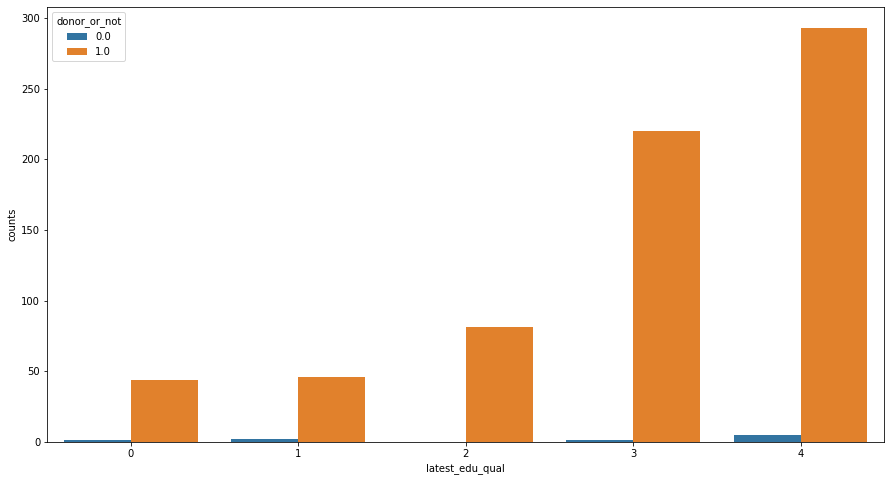

In [41]:
plot_cat_col(df_train,'latest_edu_qual')
# not much of info or any class showing towards donor = 0

-------------------------
Printing top 6 value types
45    197
44     81
43     27
42     25
39     20
36     19
Name: yrs_exp, dtype: int64


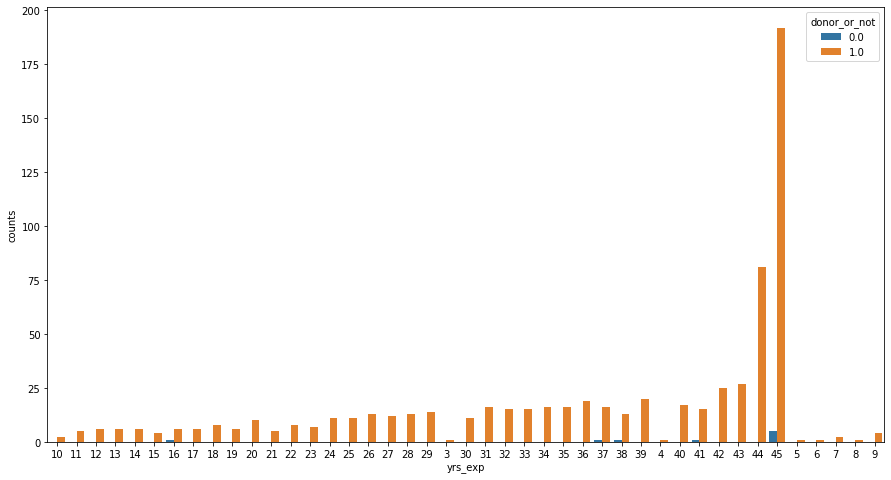

In [42]:
plot_cat_col(df_train,'yrs_exp')
# not so great info even from here. Just need to do repsonse score here as well

-------------------------
Printing top 6 value types
51    68
50    33
48    29
47    26
39    24
43    24
Name: Age, dtype: int64


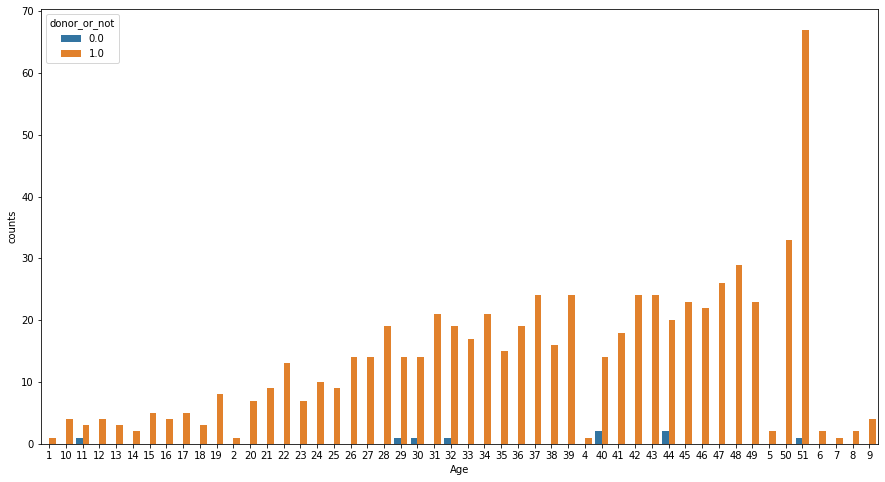

In [43]:
plot_cat_col(df_train,'Age')
# no single value type of age is dominating here

-------------------------
Printing top 6 value types
28    86
26    70
27    66
25    47
23    42
22    36
Name: District, dtype: int64


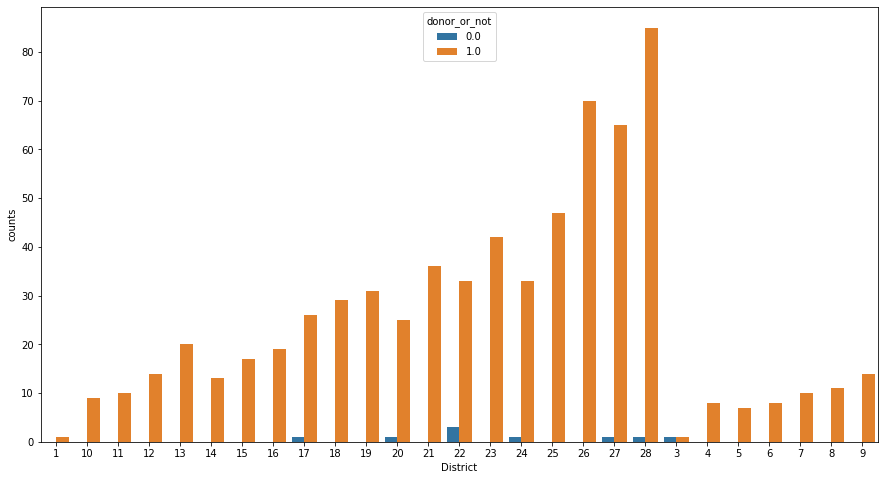

In [44]:
plot_cat_col(df_train,'District')
# no so great info from here. need to apply response scoring

-------------------------
Printing top 6 value types
22    447
21     81
20     63
19     40
18     25
17     14
Name: Nationality_label_encoded, dtype: int64


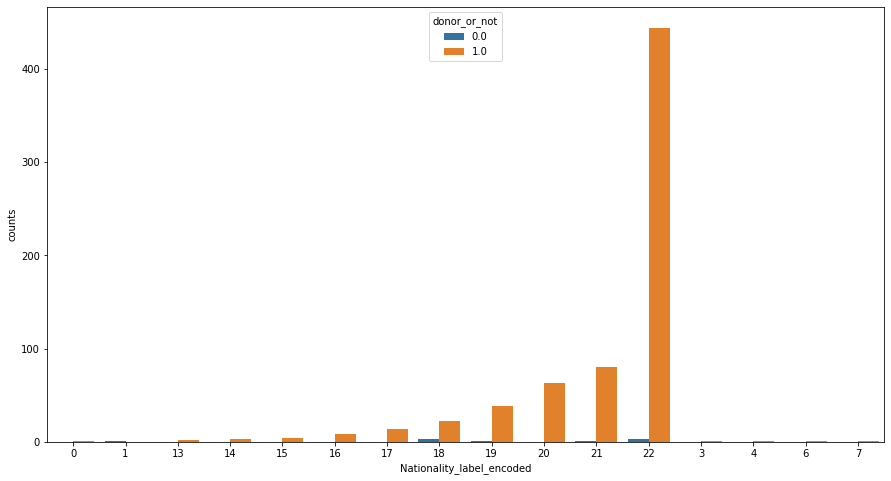

In [45]:
plot_cat_col(df_train,'Nationality_label_encoded')
# same is the case here as well

-------------------------
Printing top 6 value types
821    20
822    19
820    13
817    10
819     8
815     8
Name: latest_position, dtype: int64


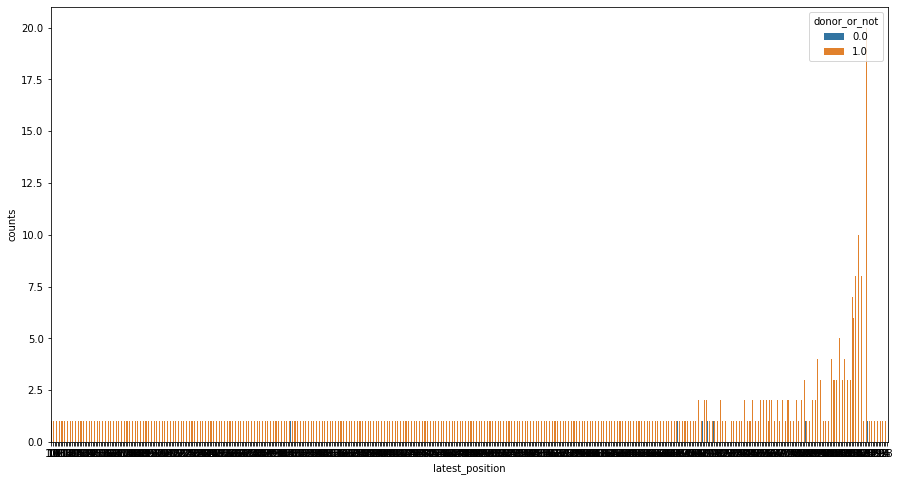

In [46]:
plot_cat_col(df_train,'latest_position')


# there are few `latest positions` that are oriented towards being a donor as we can see.
#However, there are 822 classes, so it is quite possible to overfit if we consider this as response score method here.
# But there seems we only have info about all the features in terms of catgories only

-------------------------
Printing top 6 value types
901    28
900    14
899    11
898    10
897     7
896     6
Name: current_company, dtype: int64


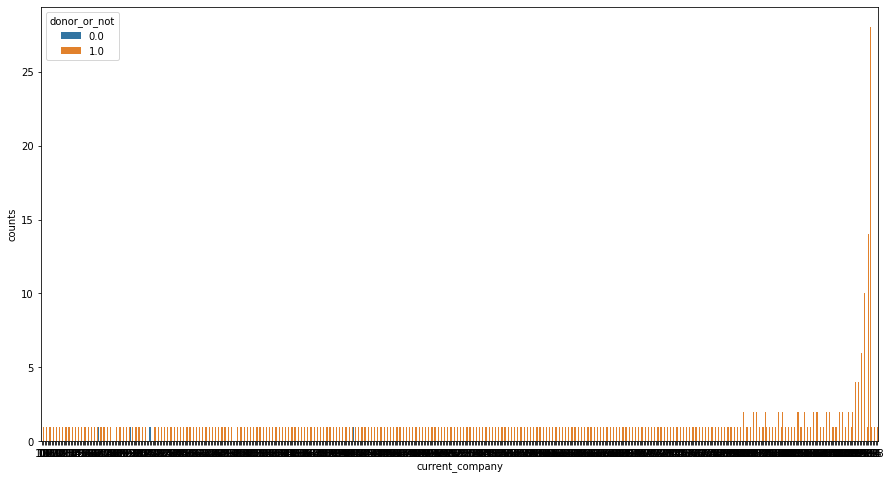

In [47]:
plot_cat_col(df_train,'current_company')

#same is the case here as well like `latest position`

In [48]:
high_cat_cols=['latest_position','current_company','latest_edu_place','yrs_exp','Age','District','Nationality_label_encoded']

In [49]:
for cols in high_cat_cols:
  df_real=response_score(cols,df_train,df_real)
  df_train=response_score(cols,df_train,df_train)
  df_test=response_score(cols,df_train,df_test)

  latest_position  total_cnt  don1_cnt  don0_cnt  latest_position_don1_response  latest_position_don0_response
0               1          1       1.0       0.0                            1.0                            0.0
1              10          1       1.0       0.0                            1.0                            0.0
  latest_position  total_cnt  don1_cnt  don0_cnt  latest_position_don1_response  latest_position_don0_response
0               1          1       1.0       0.0                            1.0                            0.0
1              10          1       1.0       0.0                            1.0                            0.0
  latest_position  total_cnt  don1_cnt  don0_cnt  latest_position_don1_response  latest_position_don0_response
0               1          1       1.0       0.0                            1.0                            0.0
1              10          1       1.0       0.0                            1.0                            0.0
 

In [50]:
df_real.drop(high_cat_cols,axis=1,inplace=True)
df_train.drop(high_cat_cols,axis=1,inplace=True)
df_test.drop(high_cat_cols,axis=1,inplace=True)
df_real.drop('location',axis=1,inplace=True)
df_train.drop('location',axis=1,inplace=True)
df_test.drop('location',axis=1,inplace=True)

In [51]:
df_real.isnull().sum()

name                                       0
latest_edu_qual                            0
volunteer_flag                             0
children_flag                              0
Has 1 Kid                                  0
Has 2-3 Kids                               0
Has More Than 3 Kids                       0
Alum Family                                0
Stay with Parents                          0
Is Alumnus                                 0
Is Staff                                   0
Is Student                                 0
Is Parent                                  0
IsAddressAvailable                         0
IsEmailAvailable                           0
IsPhoneAvailable                           0
Marital status_label_encoded               0
Gender_label_encoded                       0
donor_or_not                               2
location_don1_response                     0
location_don0_response                     0
latest_position_don1_response              0
latest_pos

In [52]:
df_train['Has 1 Kid'].value_counts()

2    689
1      4
Name: Has 1 Kid, dtype: int64

In [53]:
low_cat_cols=["latest_edu_qual" ,                           
"volunteer_flag" ,                                                        
"children_flag" ,                             
"Has 1 Kid" ,                              
"Has 2-3 Kids"   ,
"Has More Than 3 Kids" ,                  
"Alum Family" ,                              
"Stay with Parents" ,                         
"Is Alumnus",                                
"Is Staff"  ,                                
"Is Student",                                
"Is Parent" ,                                 
"IsAddressAvailable",                         
"IsEmailAvailable" ,                          
"IsPhoneAvailable",                           
"Marital status_label_encoded",              
"Gender_label_encoded"] 

-------------------------
Printing top 6 value types
4    298
3    221
2     81
1     48
0     45
Name: latest_edu_qual, dtype: int64


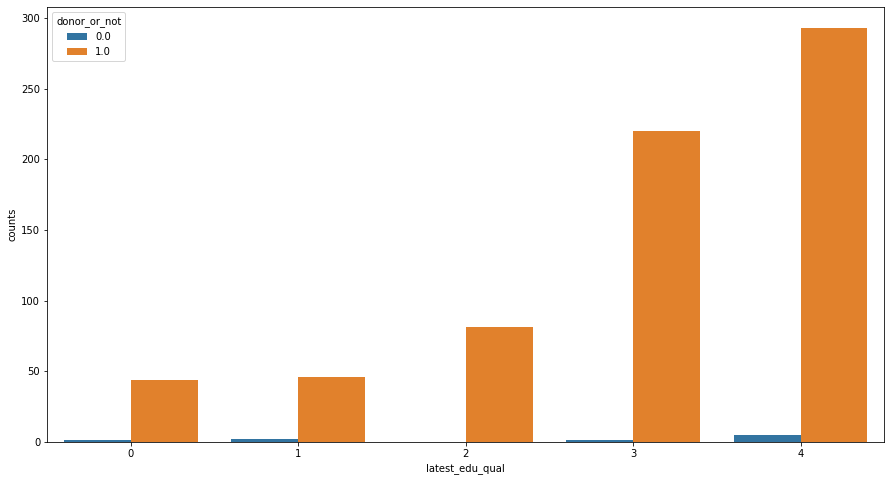

-------------------------
Printing top 6 value types
1    582
0    111
Name: volunteer_flag, dtype: int64


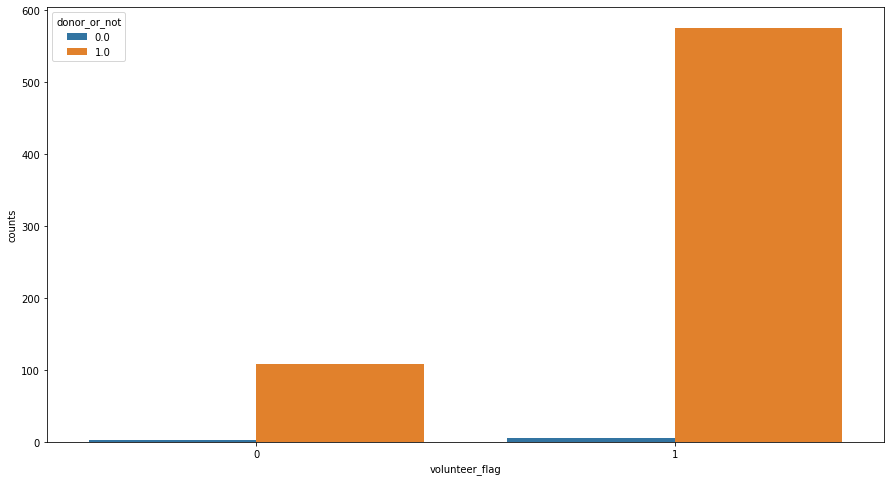

-------------------------
Printing top 6 value types
1    660
0     33
Name: children_flag, dtype: int64


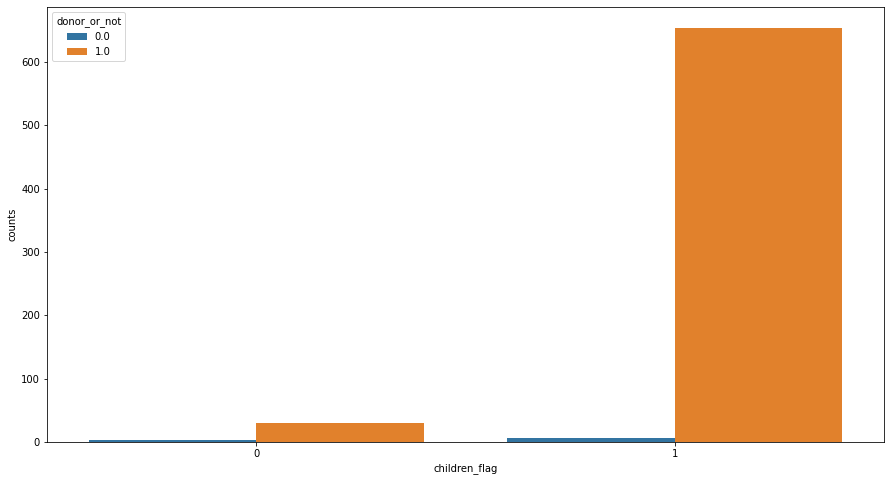

-------------------------
Printing top 6 value types
2    689
1      4
Name: Has 1 Kid, dtype: int64


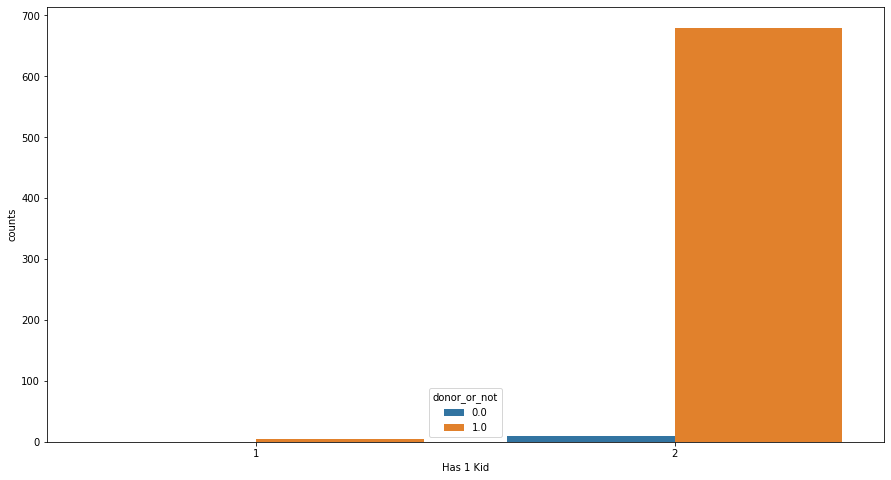

-------------------------
Printing top 6 value types
2    692
0      1
Name: Has 2-3 Kids, dtype: int64


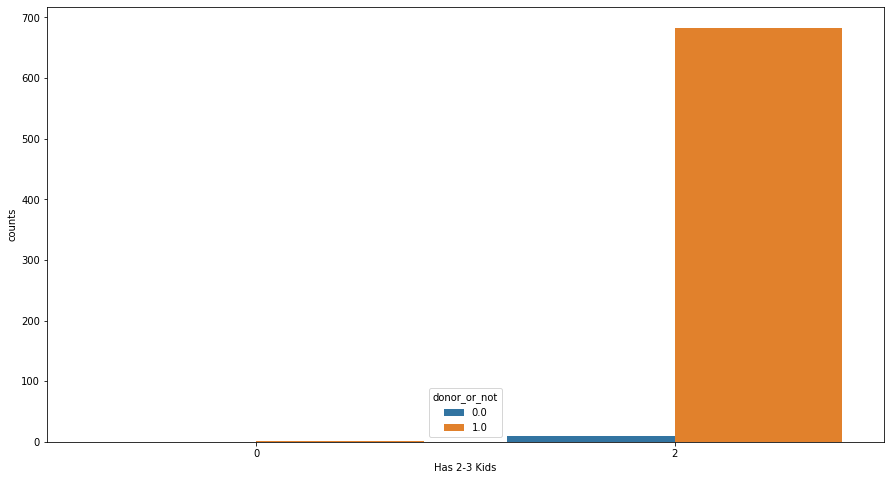

-------------------------
Printing top 6 value types
1    693
Name: Has More Than 3 Kids, dtype: int64


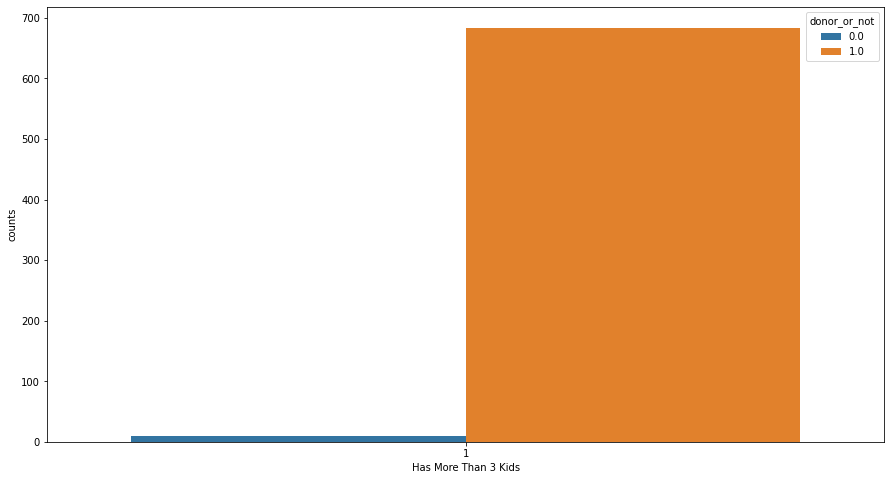

-------------------------
Printing top 6 value types
2    616
1     77
Name: Alum Family, dtype: int64


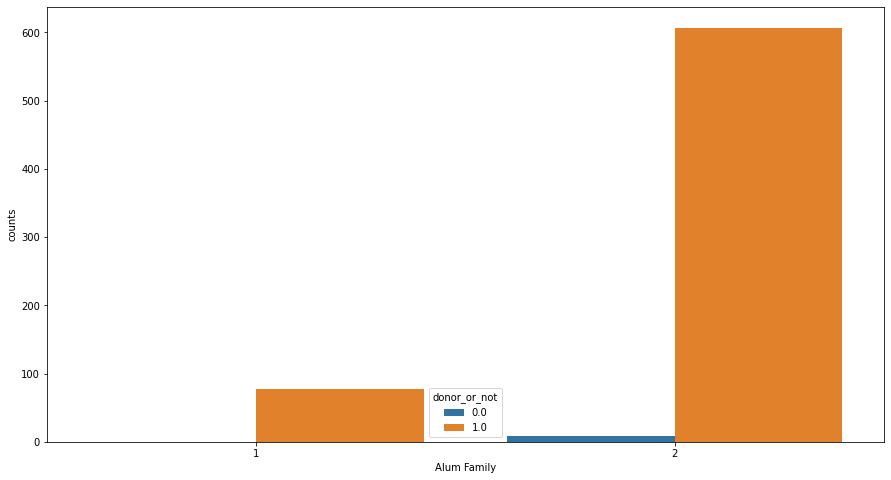

-------------------------
Printing top 6 value types
2    688
1      5
Name: Stay with Parents, dtype: int64


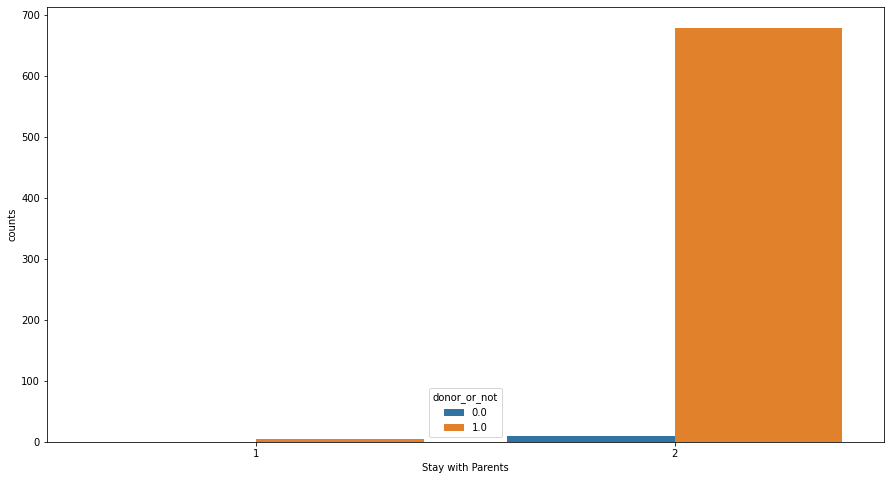

-------------------------
Printing top 6 value types
2    625
1     68
Name: Is Alumnus, dtype: int64


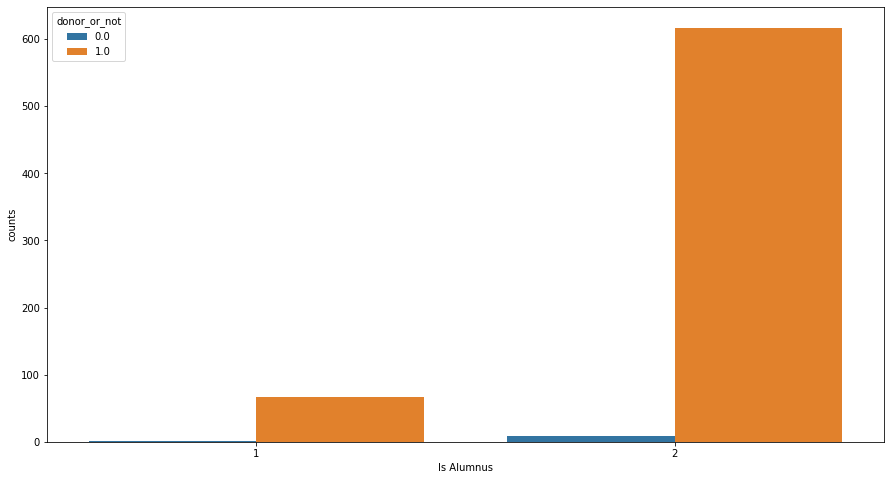

-------------------------
Printing top 6 value types
2    622
1     71
Name: Is Staff, dtype: int64


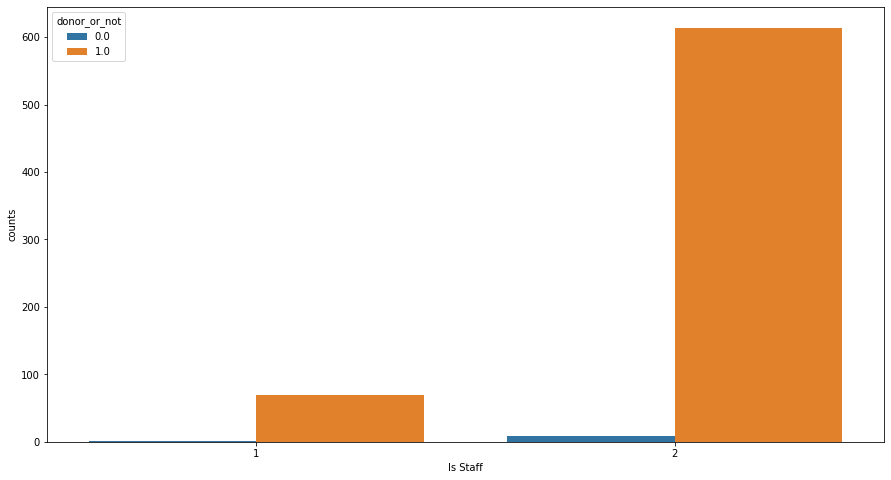

-------------------------
Printing top 6 value types
2    693
Name: Is Student, dtype: int64


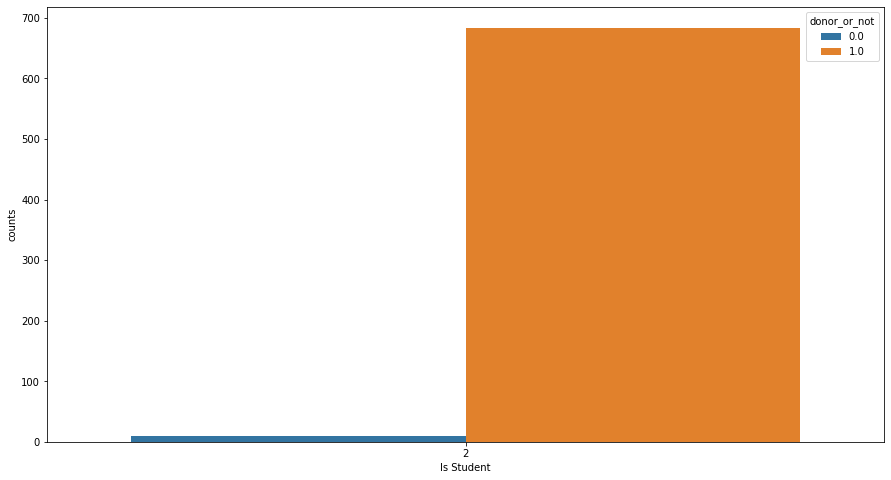

-------------------------
Printing top 6 value types
1    693
Name: Is Parent, dtype: int64


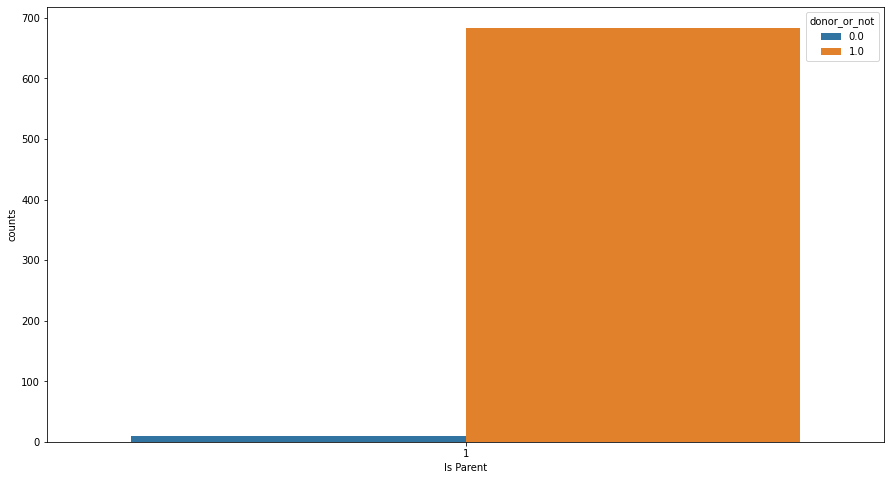

-------------------------
Printing top 6 value types
2    674
1     19
Name: IsAddressAvailable, dtype: int64


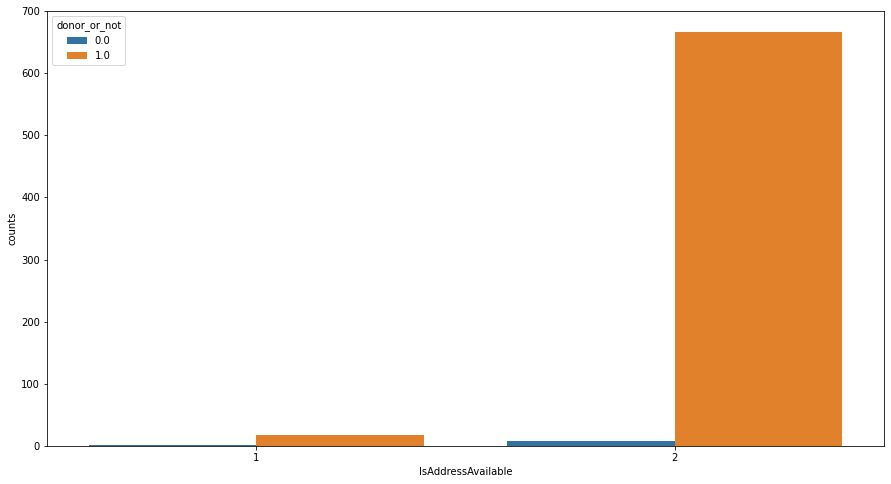

-------------------------
Printing top 6 value types
2    677
1     16
Name: IsEmailAvailable, dtype: int64


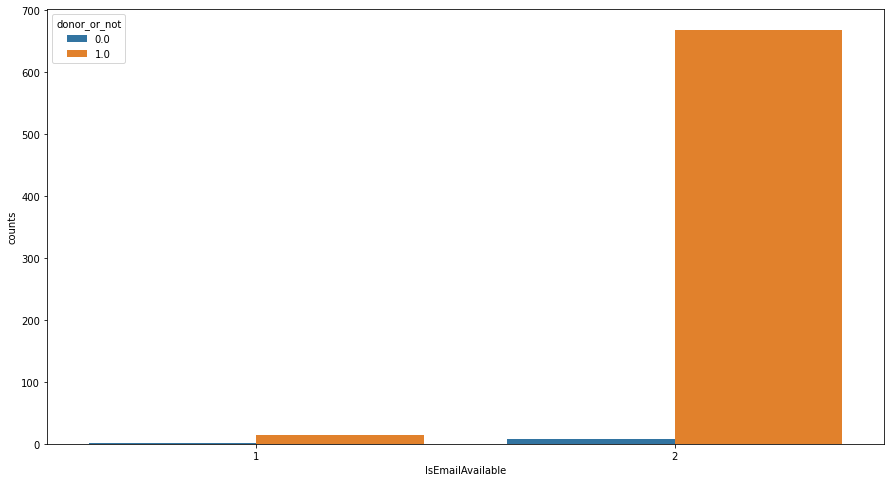

-------------------------
Printing top 6 value types
2    678
1     15
Name: IsPhoneAvailable, dtype: int64


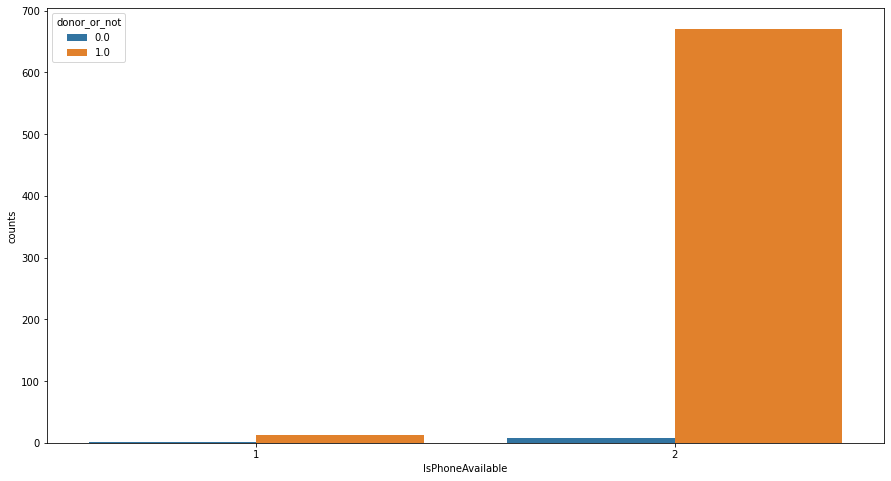

-------------------------
Printing top 6 value types
4    398
3    207
2     87
0      1
Name: Marital status_label_encoded, dtype: int64


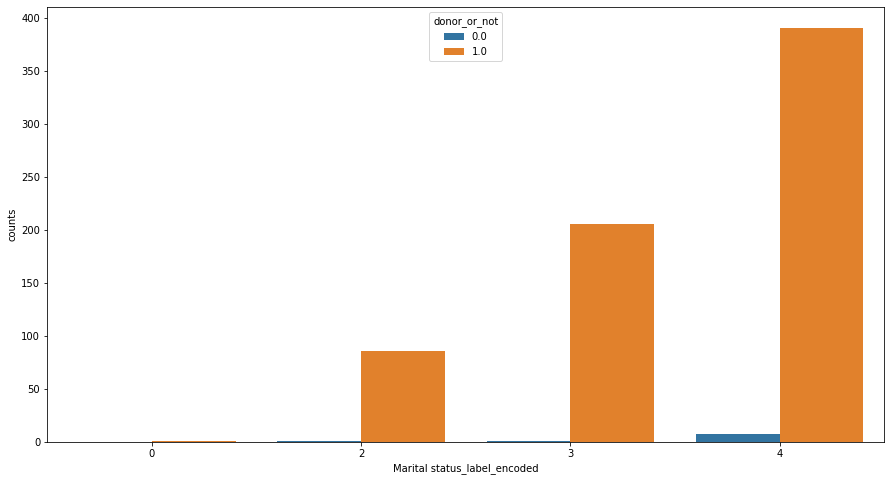

-------------------------
Printing top 6 value types
3    429
2    228
1     36
Name: Gender_label_encoded, dtype: int64


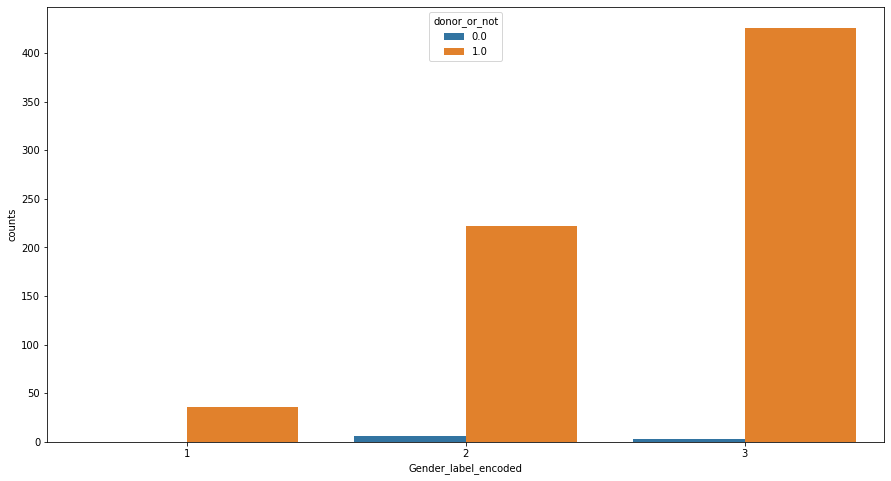

In [54]:
for cols in low_cat_cols:
  plot_cat_col(df_train,cols)

In [55]:
for cols in low_cat_cols:
  df_real[cols]=df_real[cols].astype(int)
  df_train[cols]=df_train[cols].astype(int)
  df_test[cols]=df_test[cols].astype(int)

In [56]:
df_train.donor_or_not  = df_train.donor_or_not.astype(int)
df_test.donor_or_not  = df_test.donor_or_not.astype(int)

In [57]:
# de- concating the train and test in order to fit a model
X_train, X_test, y_train, y_test = df_train.drop(['name','donor_or_not'],axis=1),df_test.drop(['name','donor_or_not'],axis=1),df_train.donor_or_not,df_test.donor_or_not

In [58]:
y_train.value_counts()

1    684
0      9
Name: donor_or_not, dtype: int64

In [59]:
y_test.value_counts()

1    457
0      6
Name: donor_or_not, dtype: int64

In [60]:
def feat_imp(model,X_train):
  
  feature_importance=pd.DataFrame(model.feature_importances_,np.array(X_train.columns)).reset_index()
  feature_importance.columns=['feature','weight']
  feature_importance.set_index('feature',inplace=True)
  # f = plt.figure()
  # f.set_figwidth(15)
  # f.set_figheight(8)
  feature_importance.plot(kind='bar',figsize=(15,6))
  plt.show()

In [95]:
from xgboost.sklearn import XGBClassifier
def rand_model_fit(X_train,y_train,X_test,y_test):
  param_tuning = {
        'max_depth': [2,3, 4],
        'n_estimators' : [3,4,6,7,8,10],
        'max_features' : ['sqrt', 'log2', None],
        'class_weight' : [{0: 1, 1: 1}, {0: 80, 1: 1}, {0: 10, 1: 1}, {0: 30, 1: 1},{0: 50, 1: 1}]
    }

  rand_model = RandomForestClassifier()

  
  #gsearch = GridSearchCV(estimator = rand_model,
                            # param_grid = param_tuning,                        
                            # cv = 3,
                            # n_jobs = 1,
                            # verbose = 1)

  #gsearch.fit(X_train,y_train)
  #best_params_ = gsearch.best_params_  
   

  
  # model = RandomForestClassifier(  max_depth = best_params_['max_depth'],
  #                                 n_estimators = best_params_['n_estimators'],
  #                                class_weight=best_params_['class_weight'],
  #                                max_features = best_params_['max_features'],
  #                                random_state=0)
  for class_weight in [{0: 1, 1: 1}, {0: 80, 1: 1}, {0: 10, 1: 1}, {0: 30, 1: 1},{0: 50, 1: 1}] :
    print("----------classweight : " + str(class_weight) + " --------------")
    model = RandomForestClassifier(class_weight=class_weight,random_state=0)
    model.fit(X_train, y_train)
    feat_imp(model,X_train)
    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)

    print("Classification Report: \n", classification_report(y_test, y_preds))
    Y_variables_df=pd.DataFrame({'y_test':y_test, "y_pred": y_preds})
    print("--------Confusion matrix----------")
    print(pd.crosstab(Y_variables_df.y_test,Y_variables_df.y_pred))



----------classweight : {0: 1, 1: 1} --------------


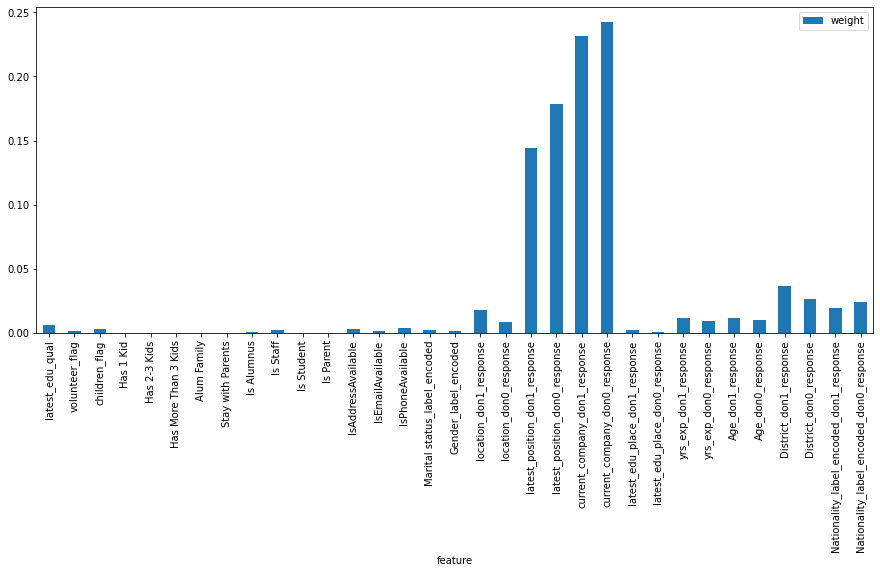

Classification Report: 
               precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
           1       0.99      0.99      0.99       457

    accuracy                           0.98       463
   macro avg       0.62      0.58      0.60       463
weighted avg       0.98      0.98      0.98       463

--------Confusion matrix----------
y_pred  0    1
y_test        
0       1    5
1       3  454
----------classweight : {0: 80, 1: 1} --------------


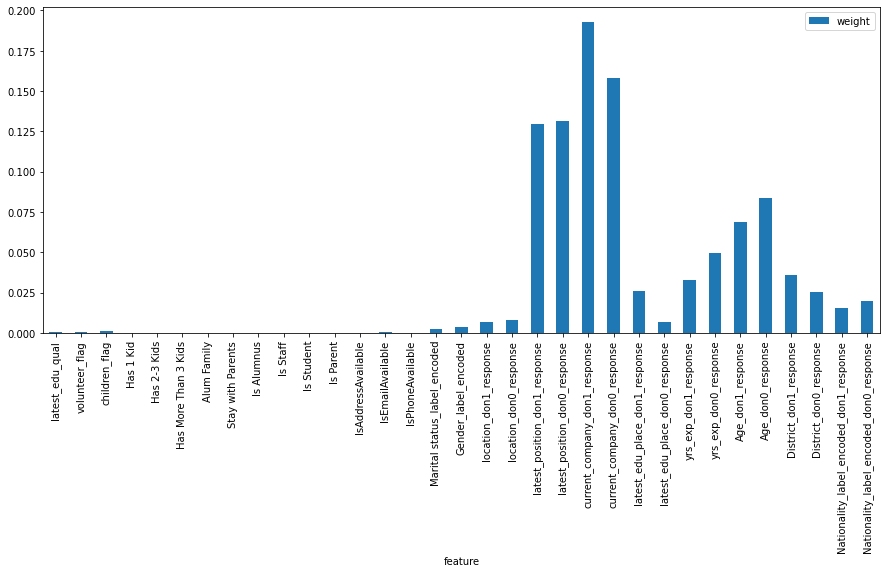

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.99      1.00      0.99       457

    accuracy                           0.99       463
   macro avg       0.49      0.50      0.50       463
weighted avg       0.97      0.99      0.98       463

--------Confusion matrix----------
y_pred    1
y_test     
0         6
1       457
----------classweight : {0: 10, 1: 1} --------------


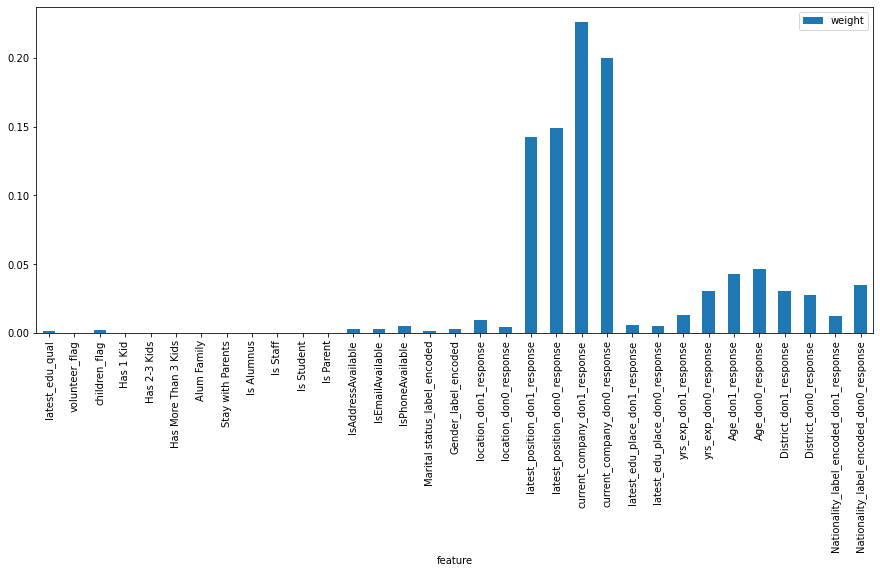

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.99      1.00      0.99       457

    accuracy                           0.99       463
   macro avg       0.49      0.50      0.50       463
weighted avg       0.97      0.99      0.98       463

--------Confusion matrix----------
y_pred    1
y_test     
0         6
1       457
----------classweight : {0: 30, 1: 1} --------------


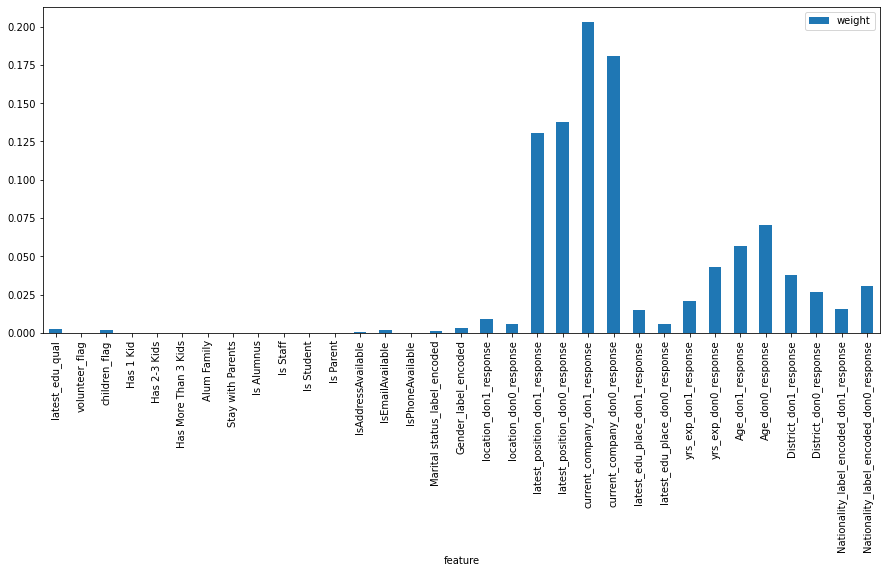

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.99      1.00      0.99       457

    accuracy                           0.99       463
   macro avg       0.49      0.50      0.50       463
weighted avg       0.97      0.99      0.98       463

--------Confusion matrix----------
y_pred    1
y_test     
0         6
1       457
----------classweight : {0: 50, 1: 1} --------------


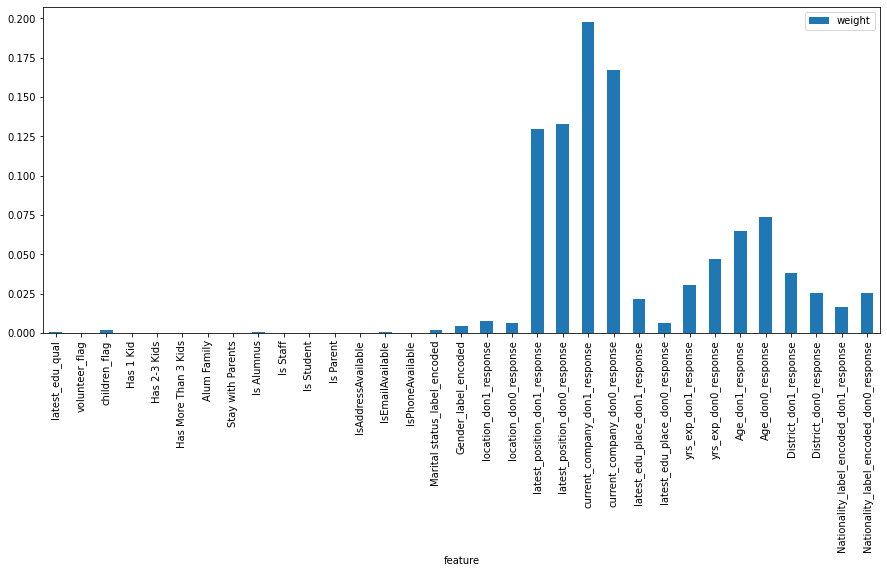

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.99      1.00      0.99       457

    accuracy                           0.99       463
   macro avg       0.49      0.50      0.50       463
weighted avg       0.97      0.99      0.98       463

--------Confusion matrix----------
y_pred    1
y_test     
0         6
1       457


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [96]:
rand_model_fit(X_train,y_train,X_test,y_test)

seems like the latest position & current company has a alot of impact on affecting the target variable


#Confusion Matrix


# We can see the f1 score here. For any imbalanced data set, we should watch out  for f1 score or higher precison or recall based on problem statement.

# we took 60 % of Train data and 40 % test data to confirm this while ensuring there are 60 : 40 % ratio for both classes


# We can see that the best f1 score of 20 % is achieved when the class weight is equal

# We can treat the data with smote to create artificial data points in order to balance the data

In [97]:
Target_data = df_real.loc[~df_real.donor_or_not.notnull(),:]

In [98]:
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer()
# vectorizer.fit(X_train.values.ravel())
# X_train=vectorizer.transform(X_train.values.ravel())
# X_test=vectorizer.transform(X_test.values.ravel())
# X_train=X_train.toarray()
# X_test=X_test.toarray()

In [99]:
# for cols in low_cat_cols:
#   df_real[cols]=df_real[cols].astype(int)
#   df_train[cols]=df_train[cols].astype(int)
#   df_test[cols]=df_test[cols].astype(int)

In [100]:
df_train.latest_edu_qual.unique()

array([1, 4, 2, 3, 0])

In [103]:
df_train.donor_or_not.value_counts()

1    684
0      9
Name: donor_or_not, dtype: int64

#Trying a model with best features 

In [104]:
best_features=['current_company_don1_response','latest_position_don1_response','current_company_don0_response','latest_position_don0_response','Age_don1_response']

----------classweight : {0: 1, 1: 1} --------------


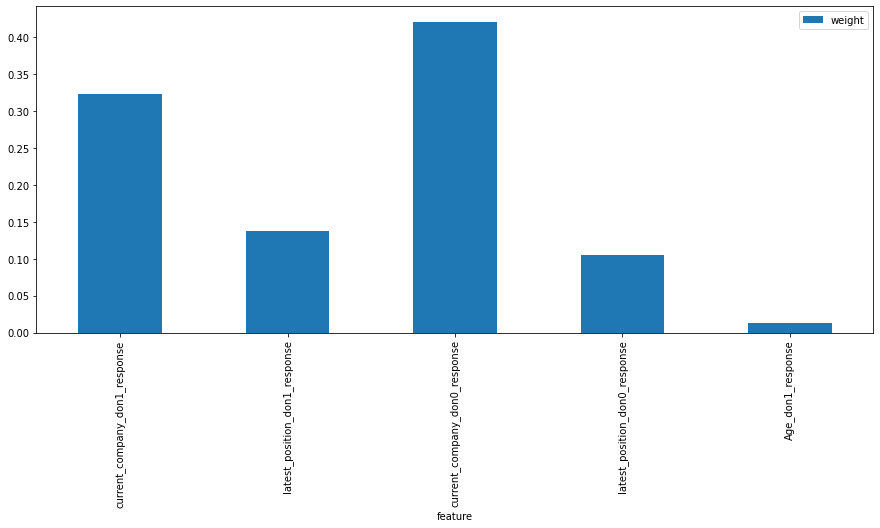

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.99      1.00      0.99       457

    accuracy                           0.98       463
   macro avg       0.49      0.50      0.50       463
weighted avg       0.97      0.98      0.98       463

--------Confusion matrix----------
y_pred  0    1
y_test        
0       0    6
1       1  456
----------classweight : {0: 80, 1: 1} --------------


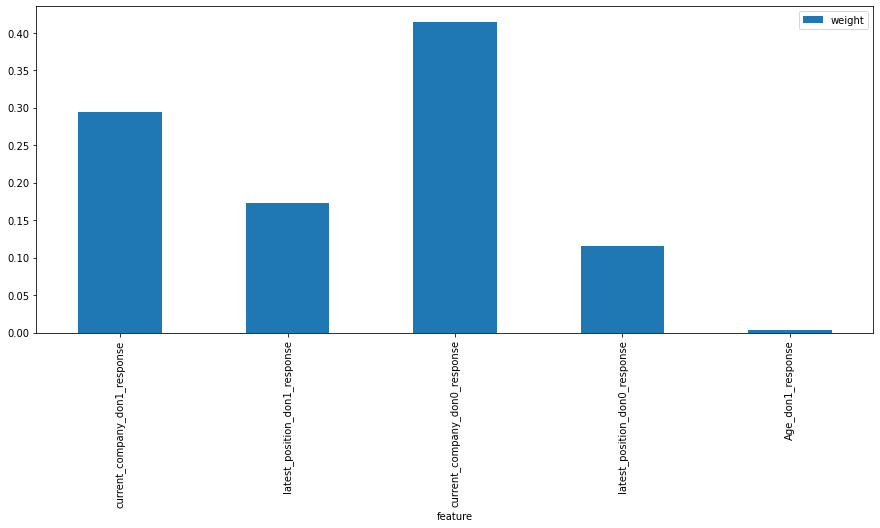

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.99      1.00      0.99       457

    accuracy                           0.99       463
   macro avg       0.49      0.50      0.50       463
weighted avg       0.97      0.99      0.98       463

--------Confusion matrix----------
y_pred    1
y_test     
0         6
1       457
----------classweight : {0: 10, 1: 1} --------------


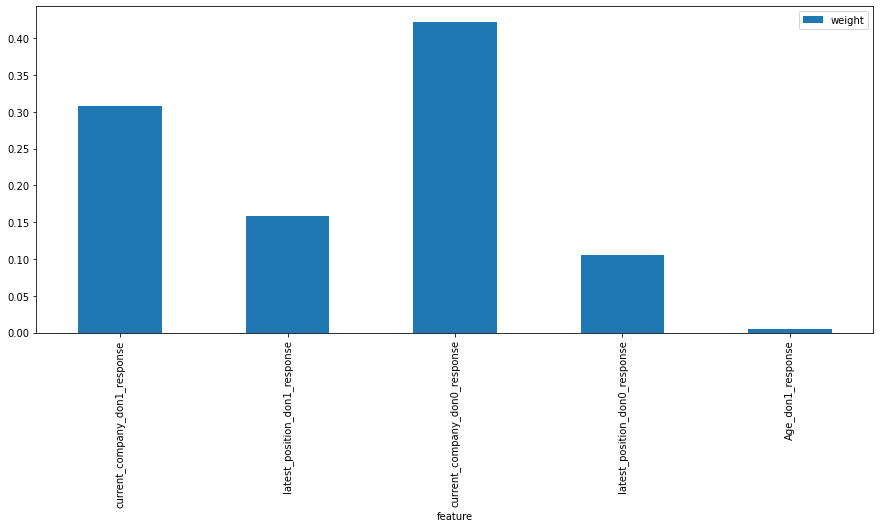

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.99      1.00      0.99       457

    accuracy                           0.99       463
   macro avg       0.49      0.50      0.50       463
weighted avg       0.97      0.99      0.98       463

--------Confusion matrix----------
y_pred    1
y_test     
0         6
1       457
----------classweight : {0: 30, 1: 1} --------------


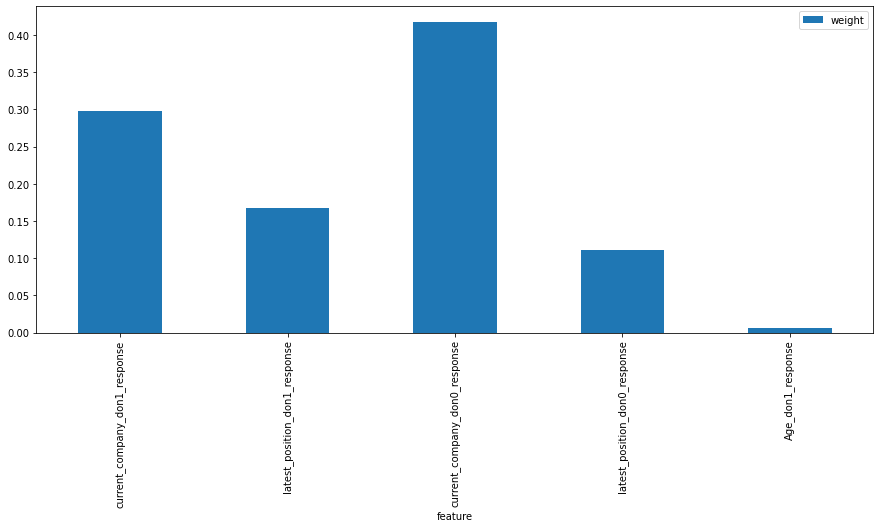

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.99      1.00      0.99       457

    accuracy                           0.99       463
   macro avg       0.49      0.50      0.50       463
weighted avg       0.97      0.99      0.98       463

--------Confusion matrix----------
y_pred    1
y_test     
0         6
1       457
----------classweight : {0: 50, 1: 1} --------------


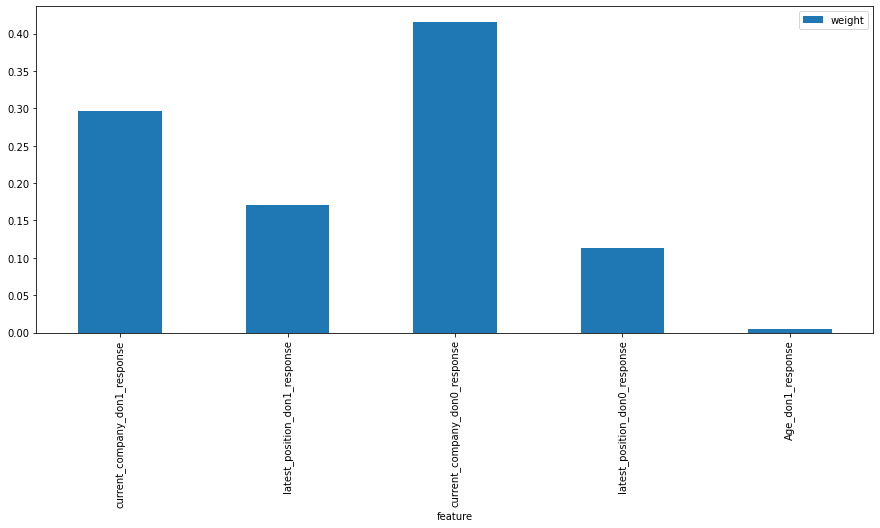

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.99      1.00      0.99       457

    accuracy                           0.99       463
   macro avg       0.49      0.50      0.50       463
weighted avg       0.97      0.99      0.98       463

--------Confusion matrix----------
y_pred    1
y_test     
0         6
1       457


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
rand_model_fit(X_train[best_features],y_train,X_test[best_features],y_test)

Actually the best features if used alone are not contributing much

##Trying SMOTE

samples
 1    684
0    684
Name: donor_or_not, dtype: int64
----------classweight : {0: 1, 1: 1} --------------


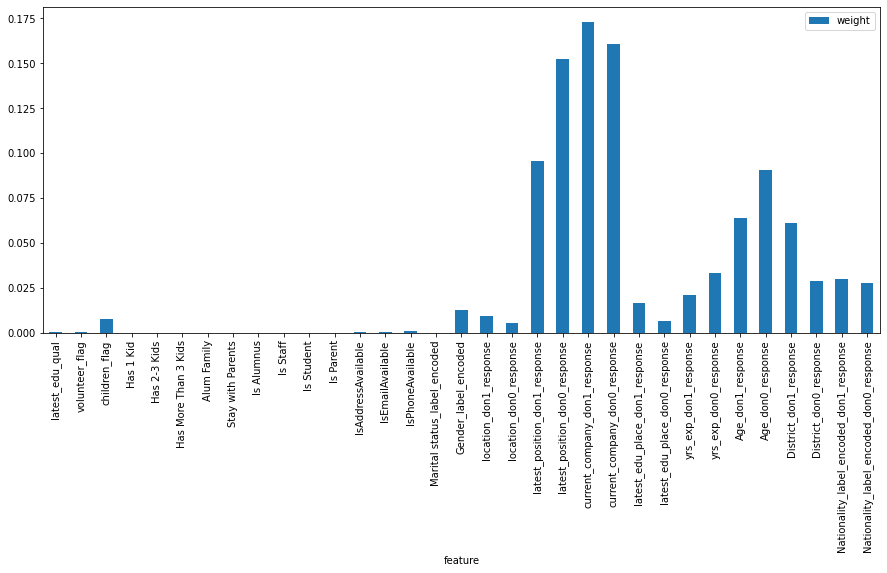

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.99      1.00      0.99       457

    accuracy                           0.98       463
   macro avg       0.49      0.50      0.50       463
weighted avg       0.97      0.98      0.98       463

--------Confusion matrix----------
y_pred  0    1
y_test        
0       0    6
1       1  456
----------classweight : {0: 80, 1: 1} --------------


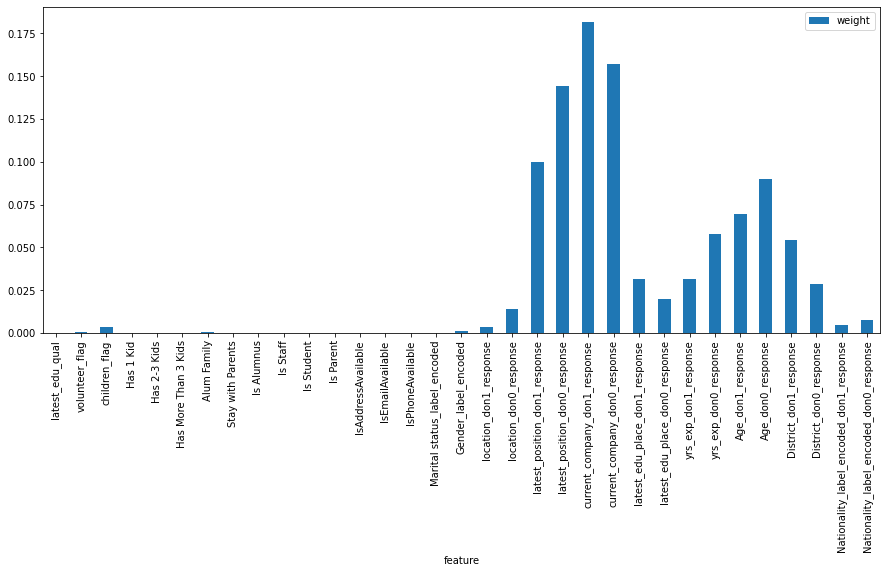

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.99      1.00      0.99       457

    accuracy                           0.99       463
   macro avg       0.49      0.50      0.50       463
weighted avg       0.97      0.99      0.98       463

--------Confusion matrix----------
y_pred    1
y_test     
0         6
1       457
----------classweight : {0: 10, 1: 1} --------------


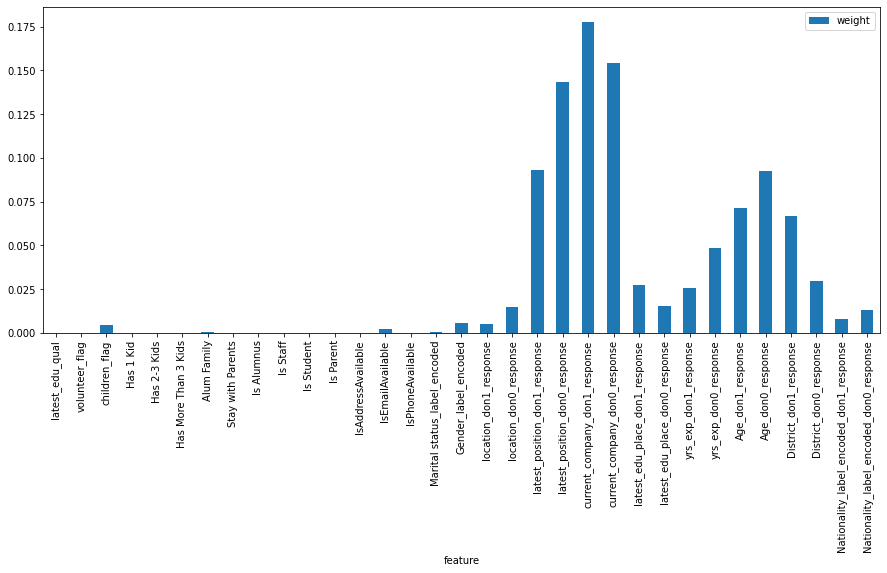

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.99      1.00      0.99       457

    accuracy                           0.99       463
   macro avg       0.49      0.50      0.50       463
weighted avg       0.97      0.99      0.98       463

--------Confusion matrix----------
y_pred    1
y_test     
0         6
1       457
----------classweight : {0: 30, 1: 1} --------------


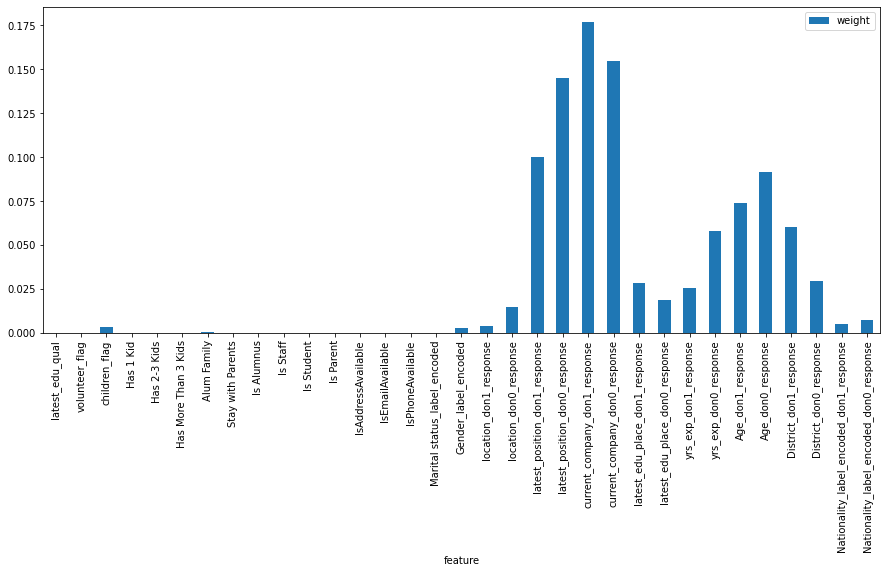

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.99      1.00      0.99       457

    accuracy                           0.99       463
   macro avg       0.49      0.50      0.50       463
weighted avg       0.97      0.99      0.98       463

--------Confusion matrix----------
y_pred    1
y_test     
0         6
1       457
----------classweight : {0: 50, 1: 1} --------------


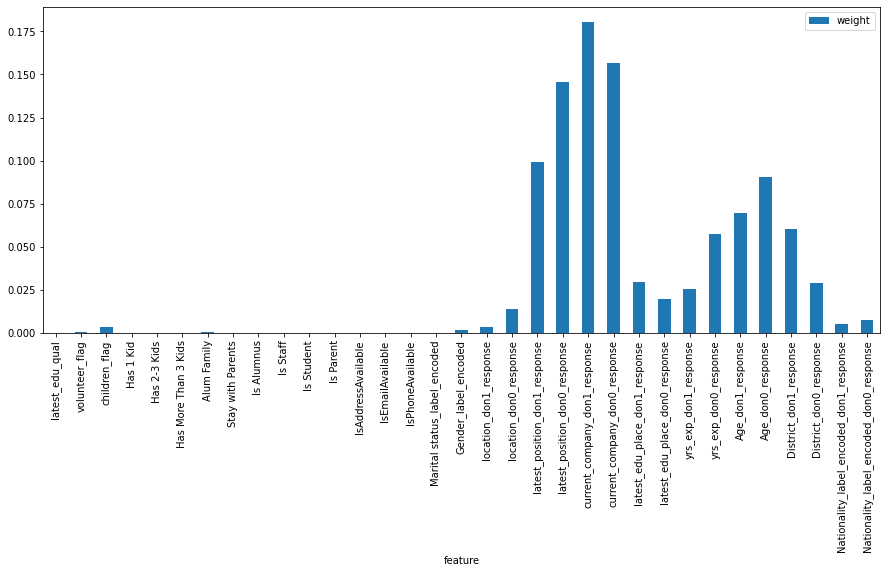

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.99      1.00      0.99       457

    accuracy                           0.99       463
   macro avg       0.49      0.50      0.50       463
weighted avg       0.97      0.99      0.98       463

--------Confusion matrix----------
y_pred    1
y_test     
0         6
1       457


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(df_train.drop(['name','donor_or_not'],axis=1),df_train.donor_or_not)
print("samples\n",y_sm.value_counts())

rand_model_fit(X_sm,y_sm,X_test,y_test)

#Even SMOTE seems to be not working well for this problem statement

In [124]:
# #!pip install catboost
# from catboost import CatBoostClassifier
 
# cat = CatBoostClassifier(
#     iterations=5, 
#     learning_rate=0.1, 
#     loss_function='CrossEntropy'
# )

# cat_features= list(X_train.columns)
# cat.fit(X_train, y_train, 
#         cat_features=cat_features, 
#         eval_set=(X_test, y_test), 
#         verbose=False
# )



Try to use the best model to predict for the target data points

In [107]:
Target_data

,name,latest_edu_qual,volunteer_flag,children_flag,Has 1 Kid,Has 2-3 Kids,Has More Than 3 Kids,Alum Family,Stay with Parents,Is Alumnus,Is Staff,Is Student,Is Parent,IsAddressAvailable,IsEmailAvailable,IsPhoneAvailable,Marital status_label_encoded,Gender_label_encoded,donor_or_not,location_don1_response,location_don0_response,latest_position_don1_response,latest_position_don0_response,current_company_don1_response,current_company_don0_response,latest_edu_place_don1_response,latest_edu_place_don0_response,yrs_exp_don1_response,yrs_exp_don0_response,Age_don1_response,Age_don0_response,District_don1_response,District_don0_response,Nationality_label_encoded_don1_response,Nationality_label_encoded_don0_response
829,806,2,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,NaN,-99.000,-99.000,1.0,0.0,-99.0,-99.0,1.00,0.00,1.0,0.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
1144,1102,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,NaN,0.977,0.023,-99.0,-99.0,-99.0,-99.0,0.98,0.02,1.0,0.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0


In [113]:
Target_data.shape

(2, 35)

#Using entire data to train with the best model

In [108]:
X = pd.concat([X_train,X_test],axis=0)
Y = pd.concat([y_train,y_test],axis=0)

In [109]:
X.shape,Y.shape

((1156, 33), (1156,))

In [111]:
class_weight = {0: 1, 1: 1}

In [112]:
model = RandomForestClassifier(class_weight=class_weight,random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 1}, random_state=0)

In [115]:
Target_data['predicted_donor_or_not'] = model.predict(Target_data.drop(['name','donor_or_not'],axis=1))

<ipython-input-115-b2aa25c219c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Target_data['predicted_donor_or_not'] = model.predict(Target_data.drop(['name','donor_or_not'],axis=1))


In [114]:
model.predict(Target_data.drop(['name','donor_or_not'],axis=1))

array([1, 1])

In [116]:
Target_data.to_csv("predicted_values.csv",index=False)

#Key Points

- Problem statement : To predict some of the alumni/ students if a University can recah out to them in order to raise a fund. Simply put the probable candidates who might donate

- Data : All the data is embeddeded and the features are catogorical

- Metric : f1 score is looked up on each iteration as we found the data to be class imbalanced

- EDA : most of the features showed negligebile to lower impact as thier affect towards the target classes. Mostly Random.

- Feature engineering : As all the features are catogorical, I used the used response score embedding for the cat features with high number of distinct values. The features with low number of distinct values are remained as it is to distinguish classes. 

- Model buiding : Tried out various tree based models and finalised the random forest model without inducing calss weight as it is affecting the perofrmance of the model. Usually tree based model work well for catogorical variables

- Optimisations & Findings : Out of all the features like the current position of a candidate and thier current company are helping a bit to classify the classes.

- Others: Even though SMOTE technique is being used, the synthetic adddition of data leads to bad performance of the model. SMOTE seems to be not to fit for this problem statement.

#Things that can be further done:

###EDA : 
- EDA should be done on the features like current company, latest position etc. 
- Bivariate analysis can be done to find different patterns.

###Feature enginerring:
- Feature enginerring can be done to use the information of combination of features
- One hot encoding can be done for features like  `latest_edu_qual`, `maritial status` etc

###Model buidling:
- Model like cat boost can be tried post converting every cat feature and doing the compatible feature engineering
- Also, hyper parameter tuning can be done to ensure the f1 score is reduced

##Alternatives:
- The problem can be tried as clustering problem and solved as well. The final two data poinst for which the donation data is missing can be tagged to one of the cluster basis its features and then we can take a majority vote of that cluster.





#Would have been great if:
 - Provided with the numerical data for the features like `age`,  `no of kids` etc
 - Provided with the data related to `income` etc
 - if the data is not embedded for some less sensible features D:



 - Thank you so much for the oppurtunity to work with one of challenging problem to solve


